# Determine rates as functions

This jupyter notebook demos you on how to specify the parameters using a python function.

This new feature enables you to enter both scalar values and a python function in the string format both in the TOML file and the API call. Using this feature the user can specify functions using the following time signatures for specifying the parameters.

def function_name():

def function_name(t):

def function_name(t,n):

def function_name(n):


## run SIRS with commuter movement in 6 US states

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.115s


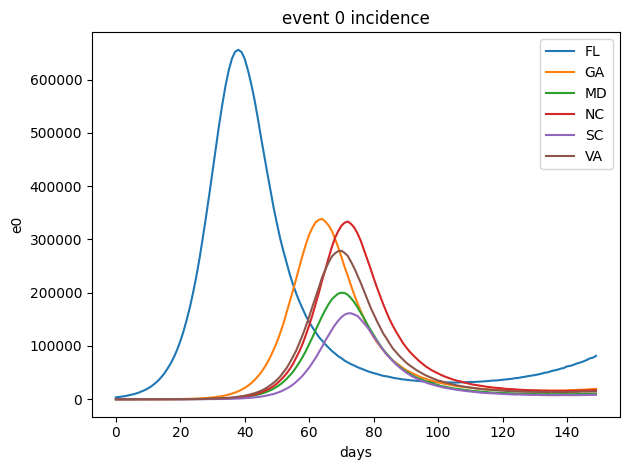

In [12]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

from epymorph.context import SimContext
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.geo import filter_geo
from epymorph.initializer import (_default_compartments, single_location,
                                  top_locations)
from epymorph.run import plot_event,plot_pop
from epymorph.simulation import Output,Simulation, with_fancy_messaging
from epymorph.util import stridesum


ipm1 = ipm_library['sirs']()
geo1 = geo_library['pei']()
mm1 = mm_library['pei']()

sim1 = with_fancy_messaging(Simulation(geo1, ipm1, mm1))

param1 = {
    # IPM params
    'beta': 0.35,
    'gamma': 1/6,
    'xi': 1/90,

    # MM params
    'theta': 0.1,
    'move_control': 0.9,
}


def init1(ctx: SimContext):
    return single_location(ctx, location=0, seed_size=10_000)


out1 = sim1.run(
    param=param1,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init1,
    rng=np.random.default_rng(1)
)

plot_event(out1, 0)

## what if beta changes by time and location?

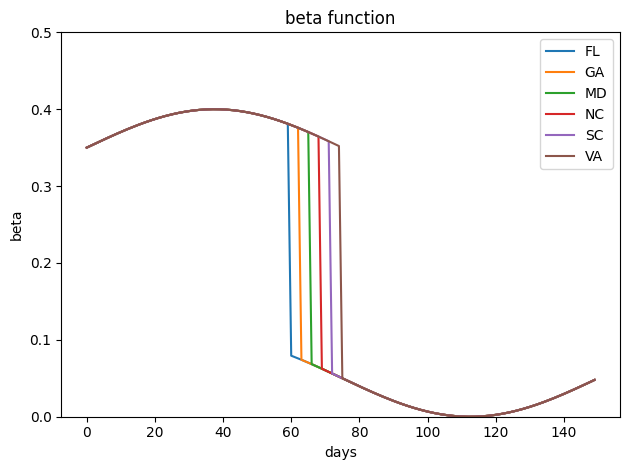

In [13]:
days = 150
t = np.arange(0, 1, 1 / days)

def beta_fn(node):
    cutoff = 60 + (node * 3)
    return (0.35 + 0.05 * np.sin(2 * np.pi * t)) - \
        (0.3 * np.concatenate((np.zeros(cutoff), np.ones(days - cutoff))))


time_varying_beta = np.array([beta_fn(n) for n in range(geo1.nodes)]).T

def plot_beta():
    fig, ax = plt.subplots()
    ax.set_title('beta function')
    ax.set_ylabel('beta')
    ax.set_xlabel('days')
    ax.set_ylim(ymin=0, ymax=0.5)
    ax.plot(np.arange(150), time_varying_beta, label=geo1.labels)
    ax.legend()
    fig.tight_layout()
    plt.show()


plot_beta()

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.122s


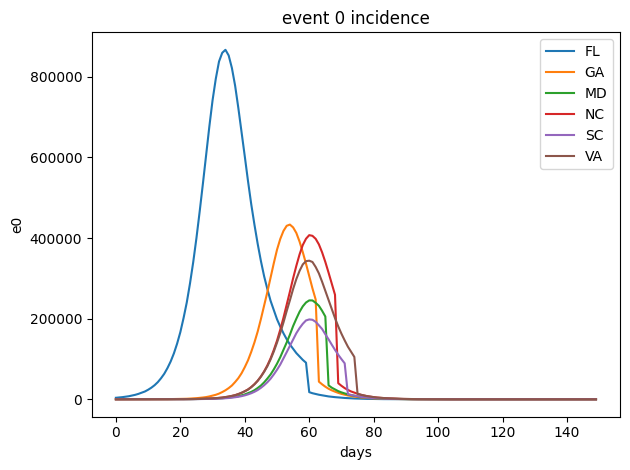

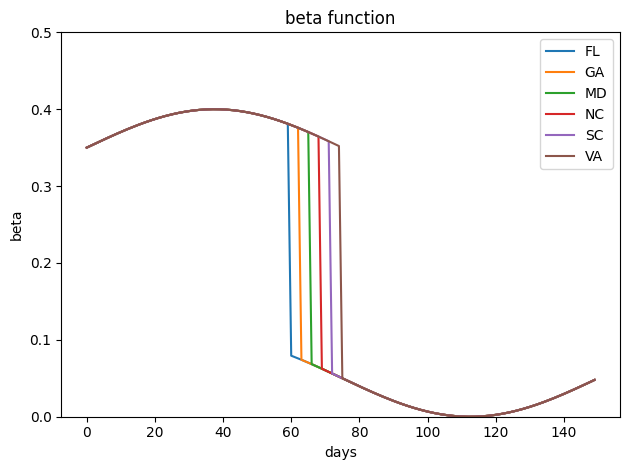

In [14]:
param2 = param1 | {
    'beta': time_varying_beta,
}

out2 = sim1.run(
    param=param2,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init1,
    rng=np.random.default_rng(1)
)

plot_event(out2, 0)
plot_beta()

# What if we can just pass that function as a parameter?

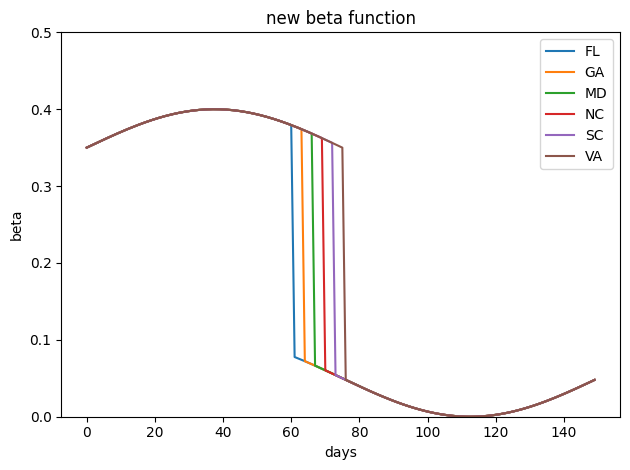

In [15]:
def beta_fn(t,n):
    days = 150
    t1 = t * (1.0 / days)
    cutoff = 60 + (n * 3)

    if(t <= cutoff):
        return (0.35 + 0.05 * np.sin(2 * np.pi * t1)) - \
        (0.3 * 0)
    else:
        return (0.35 + 0.05 * np.sin(2 * np.pi * t1)) - \
        (0.3 * 1)

duration = 150
nodes = 6

res  = np.array([[beta_fn(d, c) for d in range(duration)] for c in range(nodes)])


def plot_new_beta():
    fig, ax = plt.subplots()
    ax.set_title('new beta function')
    ax.set_ylabel('beta')
    ax.set_xlabel('days')
    ax.set_ylim(ymin=0, ymax=0.5)
    
    for i in range(len(res)):
        # Plot each set of data in 'res' with a corresponding label from 'geo1.labels'
        ax.plot(np.arange(150), res[i], label=geo1.labels[i])

    ax.legend()
    fig.tight_layout()
    plt.show()


plot_new_beta()

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.124s


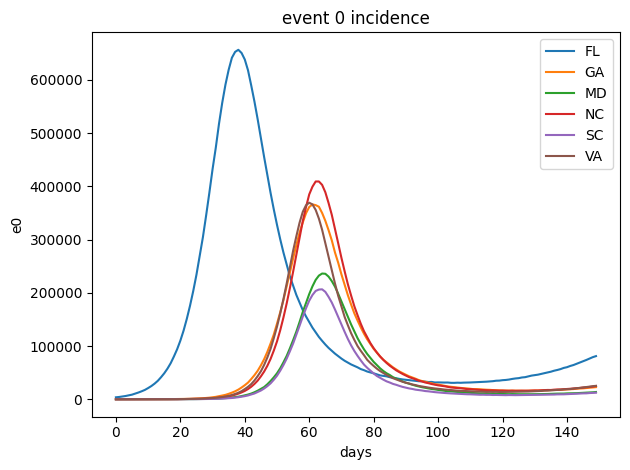

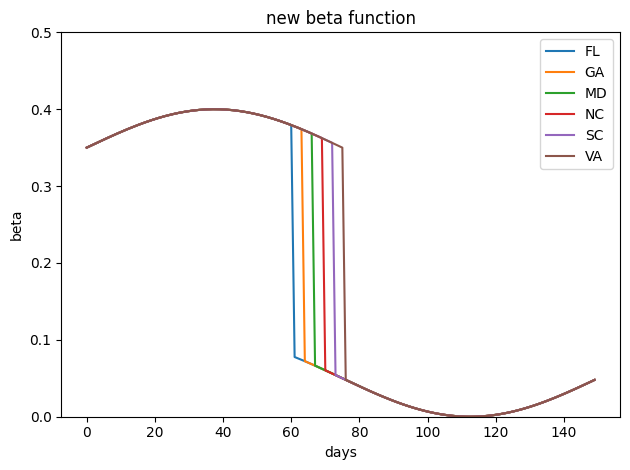

In [16]:
param2 = param1 | {
    'beta': '''def beta_fn(n,t):
    import numpy as np
    t1 = t * 0.04
    cutoff = 60 + (n * 3)

    if(t <= cutoff):
        return (0.35 + 0.05 * np.sin(2 * np.pi * t1)) - \
        (0.3 * 0)
    else:
        return (0.35 + 0.05 * np.sin(2 * np.pi * t1)) - \
        (0.3 * 1)''',
}

out3 = sim1.run(
    param=param2,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init1,
    rng=np.random.default_rng(1)
)

plot_event(out3, 0)
plot_new_beta()

# SparseMod, Pei Geoo , Pei Movement Model With Time Varying Parameters

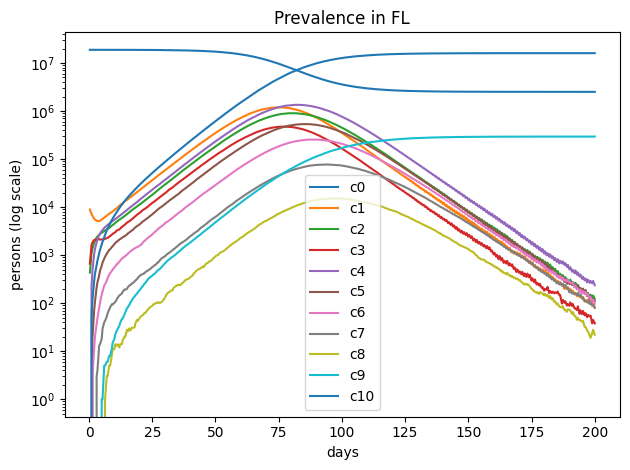

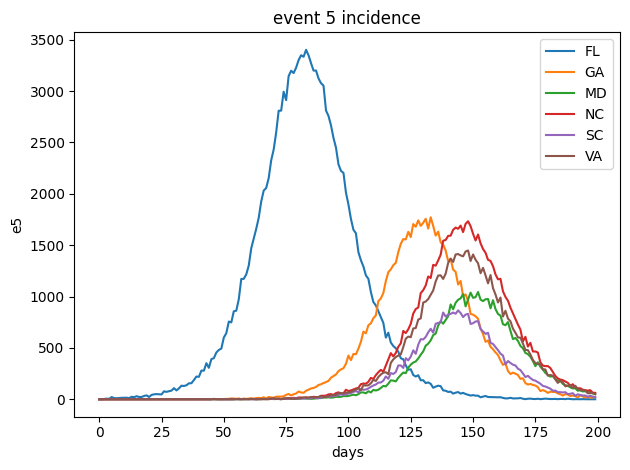

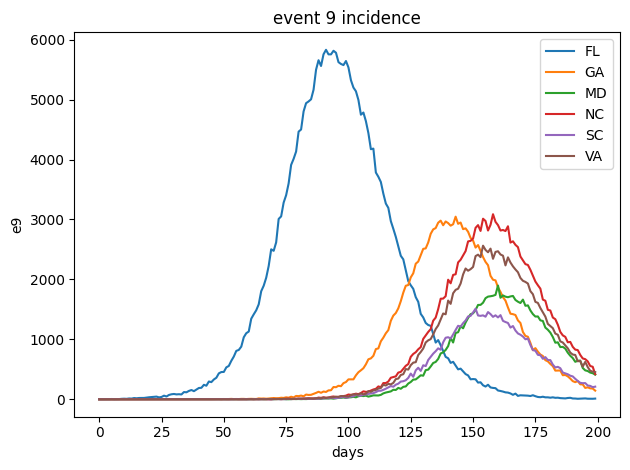

In [17]:
sim2 = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=ipm_library['sparsemod'](),
    mvm_builder=mm_library['pei']())

param1 = {
        'move_control': 1,
        'theta': 0.1,
        'beta': 0.3,
        'omega': [0.55,0.05],
        'delta': [0.333, 0.5, 0.166,0.142,0.125],
        'gamma': [0.166, 0.333, 0.25],
        'rho': [0.4, 0.175, 0.015, 0.2, 0.6]
    }

out4 = sim2.run(
    param=param1,
    start_date=date(2015, 1, 1),
    duration_days=200,
    initializer=init1,
    rng=np.random.default_rng(1)
)

plot_pop(out4, 0)  # Florida prevalence

plot_event(out4, 5)  # 5: Is->Ih: hospitalizations, non-ICU
plot_event(out4, 9)  # 9: Ic1->D: deaths

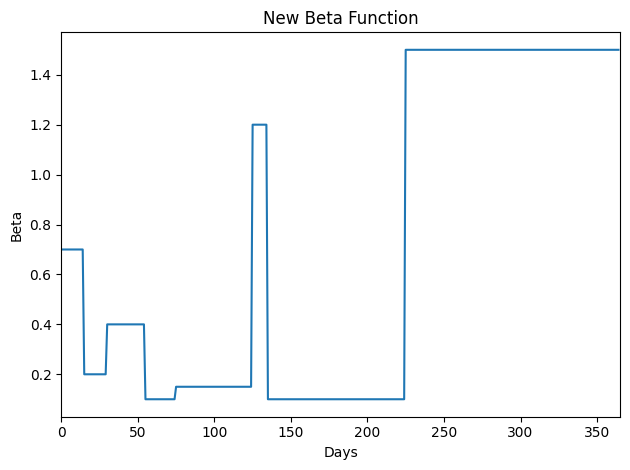

In [18]:
def calculate_beta(t):
    if 0 <= t < 15:
        return 0.7
    elif 15 <= t < 30:
        return 0.2
    elif 30 <= t < 55:
        return 0.4
    elif 55 <= t < 75:
        return 0.1
    elif 75 <= t < 125:
        return 0.15
    elif 125 <= t < 135:
        return 1.2
    elif 135 <= t < 225:
        return 0.1
    else:
        return 1.5

duration = 365

res = np.array([calculate_beta(d) for d in range(duration)])

def plot_beta_covid():
    fig, ax = plt.subplots()
    ax.set_title('New Beta Function')
    ax.set_ylabel('Beta')
    ax.set_xlabel('Days')
    ax.set_xlim(xmin=0, xmax=365)
    plt.plot(res)
    fig.tight_layout()
    plt.show()


plot_beta_covid()


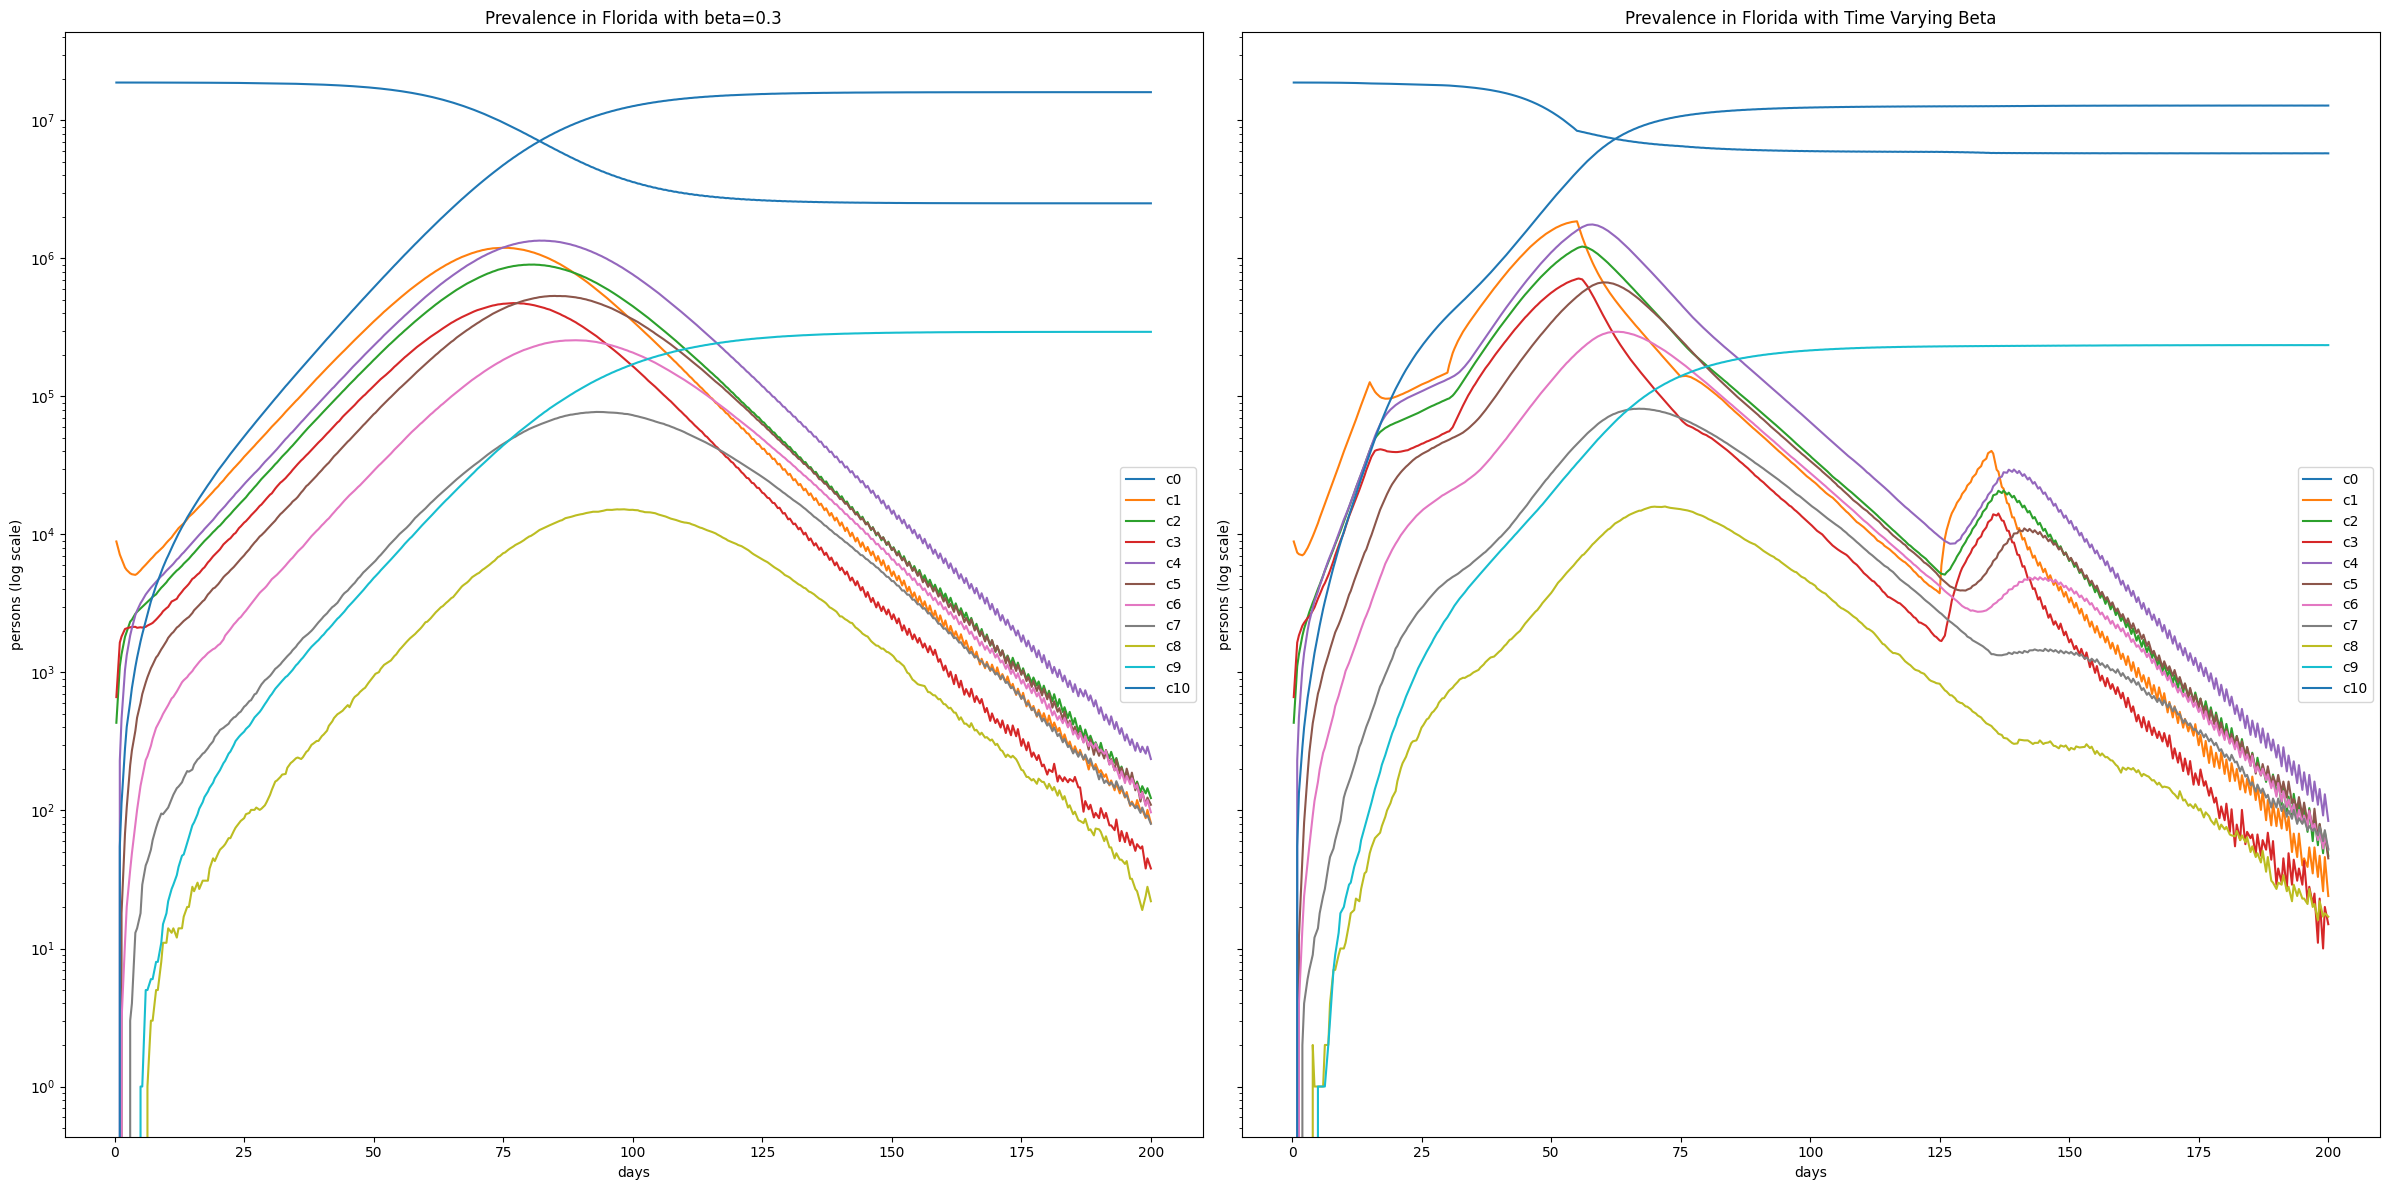

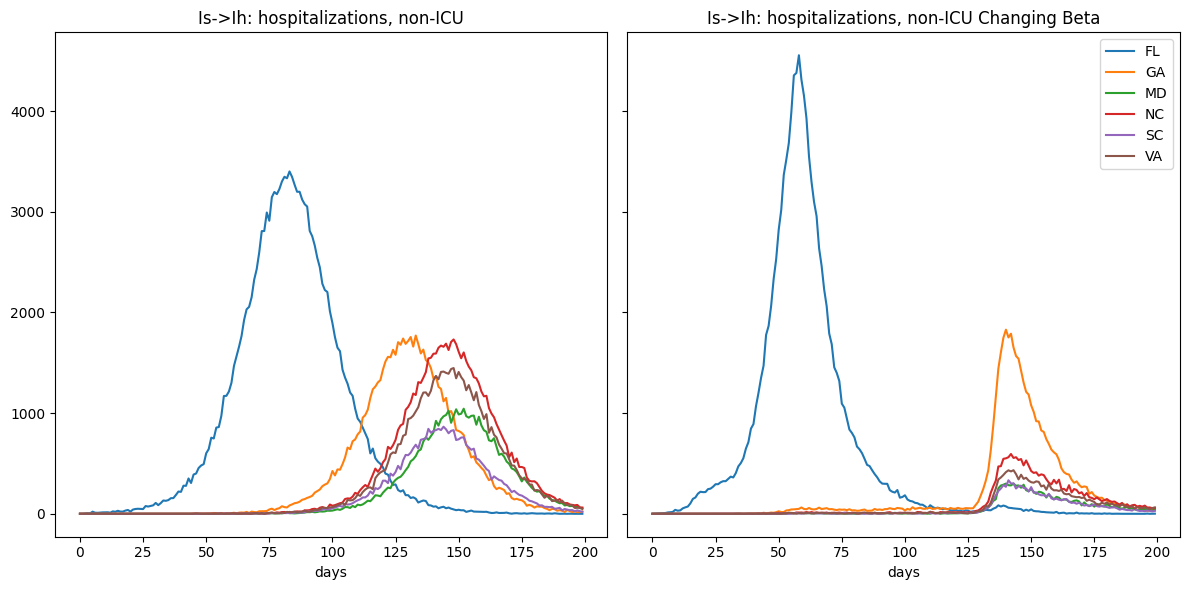

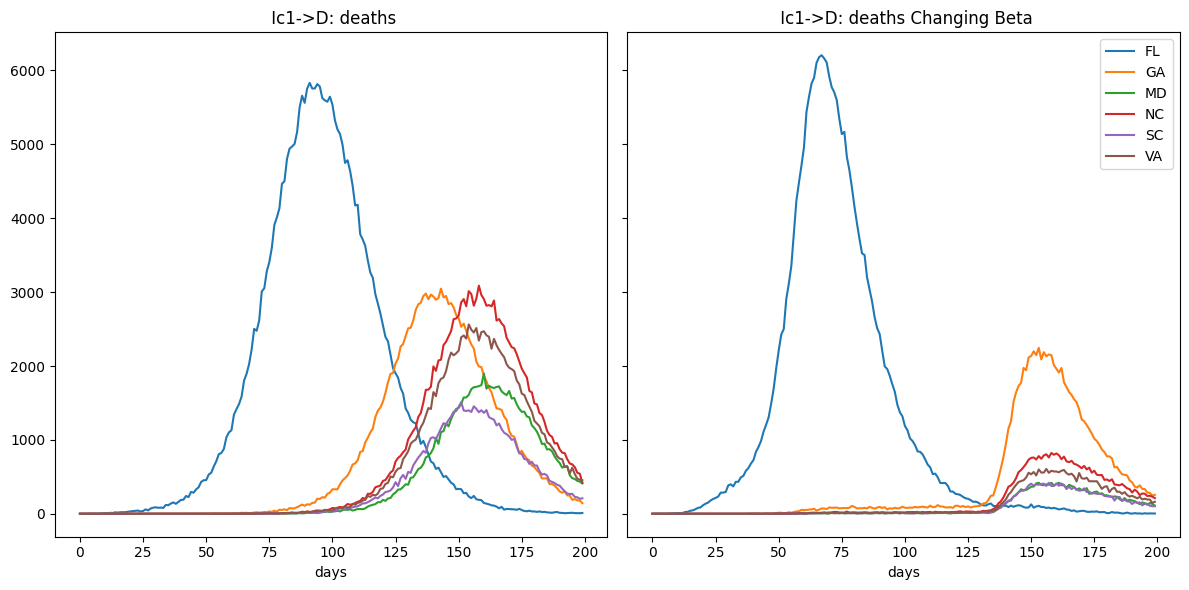

In [19]:
param2 = {
    'move_control': 1,
    'theta': 0.1,
    'beta': 0.3,
    'omega': [0.55,0.05],
    'delta': [0.333, 0.5, 0.166,0.142,0.125],
    'gamma': [0.166, 0.333, 0.25],
    'rho': [0.4, 0.175, 0.015, 0.2, 0.6],
    'beta': '''def calculate_beta(t):
    if 0 <= t < 15:
        return 0.7
    elif 15 <= t < 30:
        return 0.2
    elif 30 <= t < 55:
        return 0.4
    elif 55 <= t < 75:
        return 0.1
    elif 75 <= t < 125:
        return 0.15
    elif 125 <= t < 135:
        return 1.2
    elif 135 <= t < 225:
        return 0.1
    else:
        return 1.5''',
}


out5 = sim2.run(
    param=param2,
    start_date=date(2015, 1, 1),
    duration_days=200,
    initializer=init1,
    rng=np.random.default_rng(1)
)



def plot_subplots(out1, out2,label1, label2, figsize=(12, 6),pop1 = 0,pop2 = 0):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    
    x_axis1 = [t.tausum for t in out1.ctx.clock.ticks]
    ax1.set_title(f"{label1}")
    ax1.set_xlabel('days')
    ax1.set_ylabel('persons (log scale)')
    ax1.set_yscale('log')
    
    compartments1 = [f"c{n}" for n in range(out1.ctx.compartments)]
    for i, event in enumerate(compartments1):
        y_axis = out1.prevalence[:, pop1, i]
        ax1.plot(x_axis1, y_axis, label=event)
    if out1.ctx.compartments <= 12:
        ax1.legend()

    x_axis2 = [t.tausum for t in out2.ctx.clock.ticks]
    ax2.set_title(f"{label2}")
    ax2.set_xlabel('days')
    ax2.set_ylabel('persons (log scale)')
    ax2.set_yscale('log')
    
    compartments2 = [f"c{n}" for n in range(out2.ctx.compartments)]
    for i, event in enumerate(compartments2):
        y_axis = out2.prevalence[:, pop2, i]
        ax2.plot(x_axis2, y_axis, label=event)
    if out2.ctx.compartments <= 12:
        ax2.legend()
    
    fig.tight_layout()
    
    plt.show()

plot_subplots(out4, out5, label1="Prevalence in Florida with beta=0.3", label2="Prevalence in Florida with Time Varying Beta", pop1 = 0,pop2=0, figsize=(24, 12))

def event_y_axis(out: Output, event_idx: int) -> np.ndarray:
    """Utility function for graphing incidence time-series."""
    taus_per_day = len(out.ctx.clock.taus)
    y_values = np.zeros((out.ctx.nodes, out.ctx.clock.num_days))
    for pop_idx in range(out.ctx.nodes):
        events_by_tau = out.incidence[:, pop_idx, event_idx]
        y_values[pop_idx] = stridesum(events_by_tau, taus_per_day)
    return y_values.T

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
x_axis = np.arange(out4.ctx.clock.num_days)
ax1.plot(x_axis, event_y_axis(out4, 5), label=out4.ctx.labels)
ax2.plot(x_axis, event_y_axis(out5, 5), label=out5.ctx.labels)

ax1.set(title='Is->Ih: hospitalizations, non-ICU', xlabel='days')
ax2.set(title='Is->Ih: hospitalizations, non-ICU Changing Beta', xlabel='days')
ax2.legend()
fig.tight_layout()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
x_axis = np.arange(out4.ctx.clock.num_days)
ax1.plot(x_axis, event_y_axis(out4, 9), label=out4.ctx.labels)
ax2.plot(x_axis, event_y_axis(out5, 9), label=out5.ctx.labels)

ax1.set(title=' Ic1->D: deaths', xlabel='days')
ax2.set(title=' Ic1->D: deaths Changing Beta', xlabel='days')
ax2.legend()
fig.tight_layout()
plt.show()


## Passing a python function as a parameter to the Epymorph

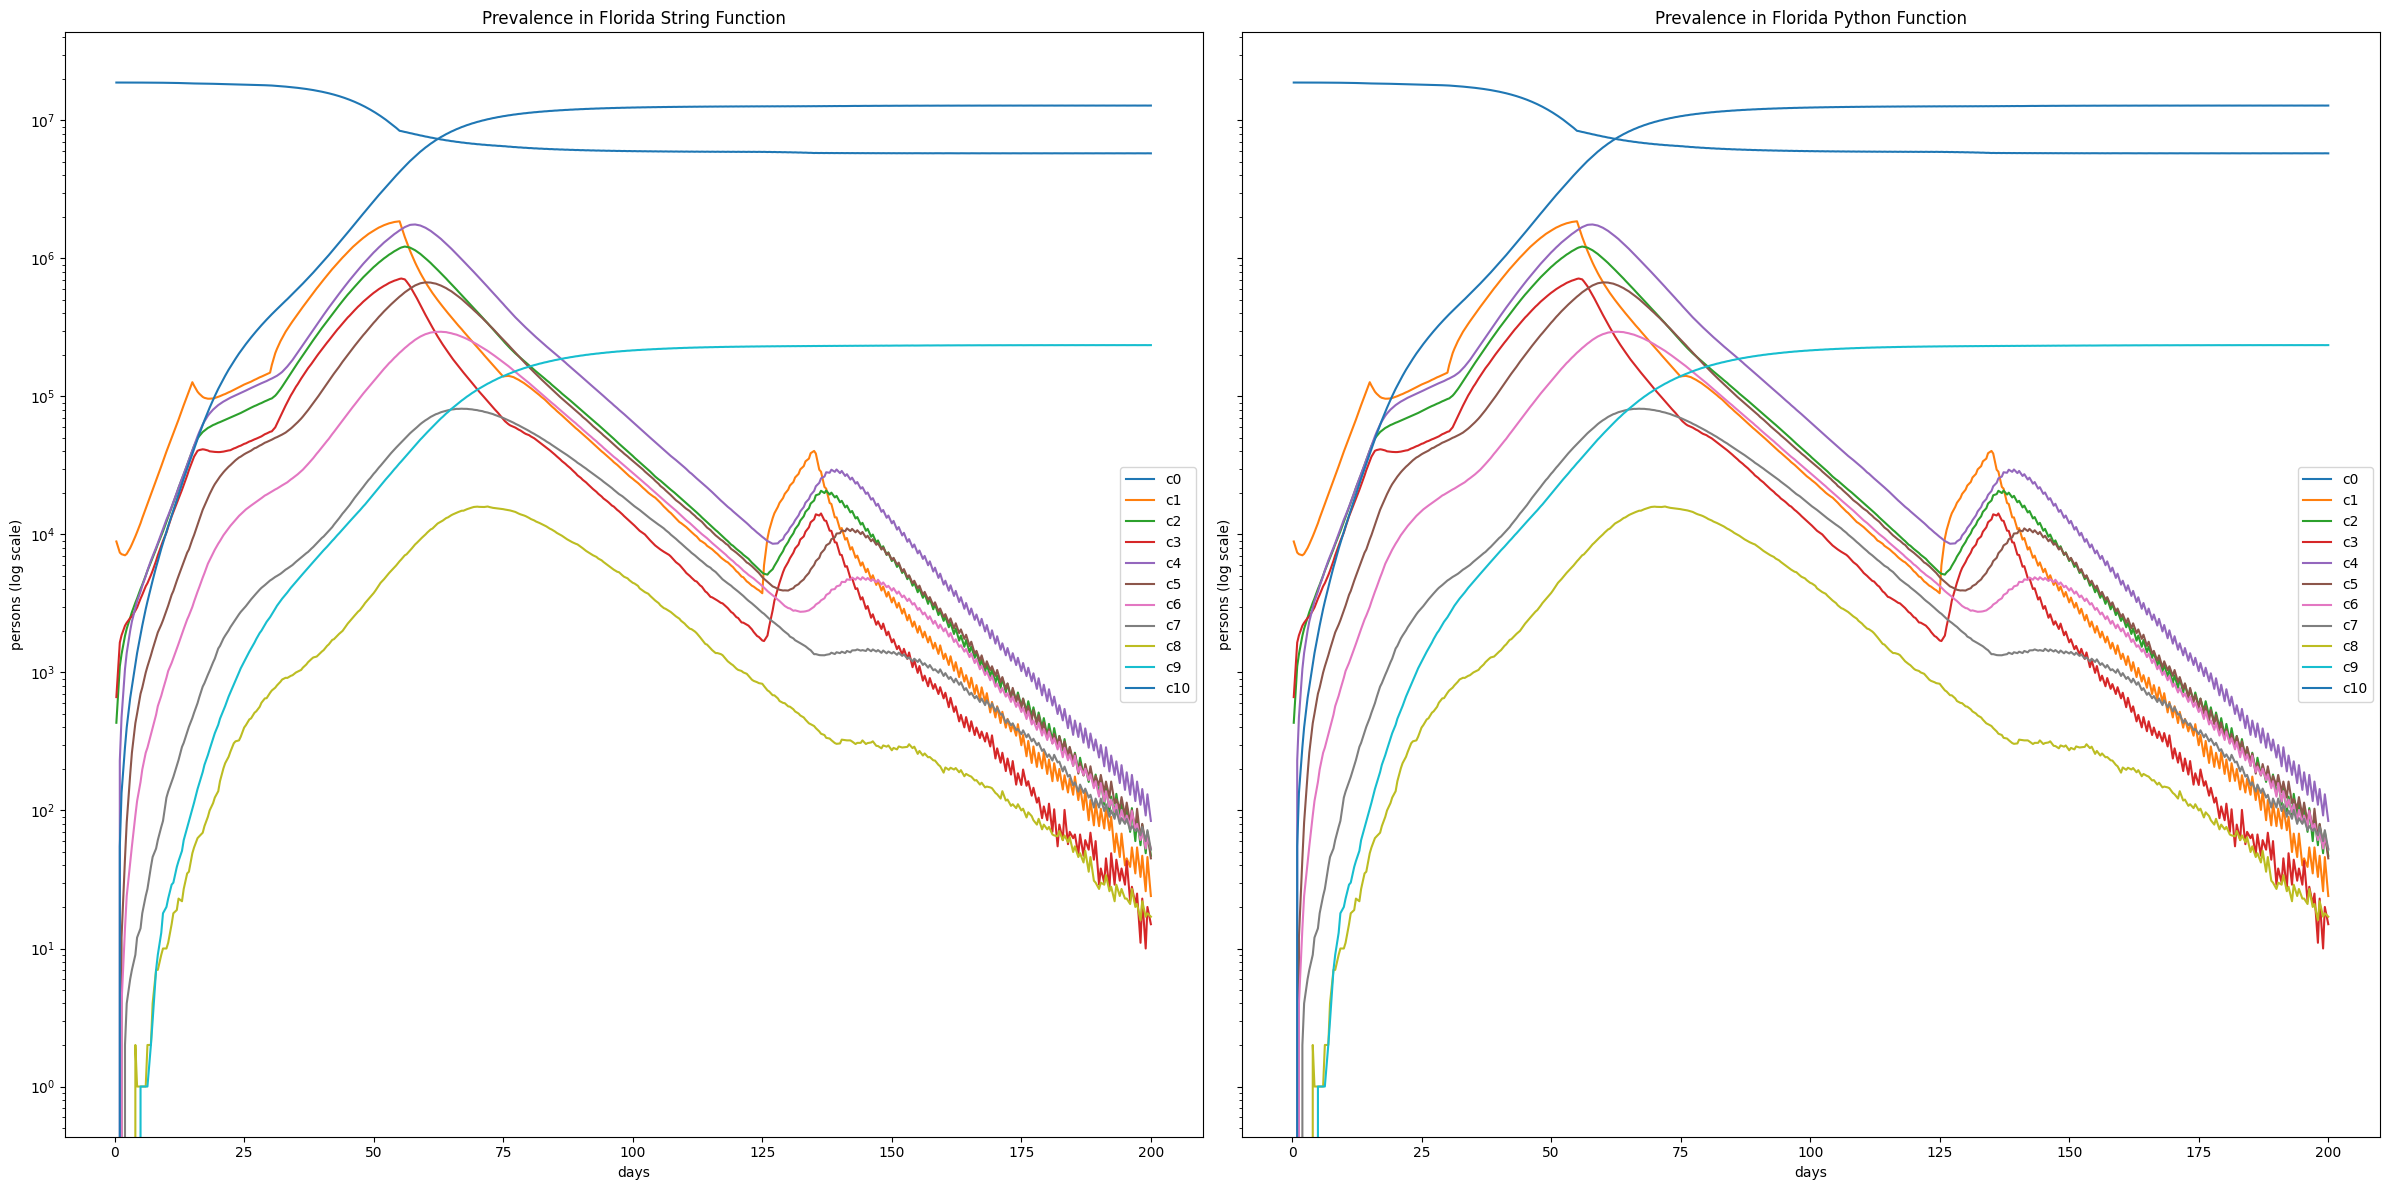

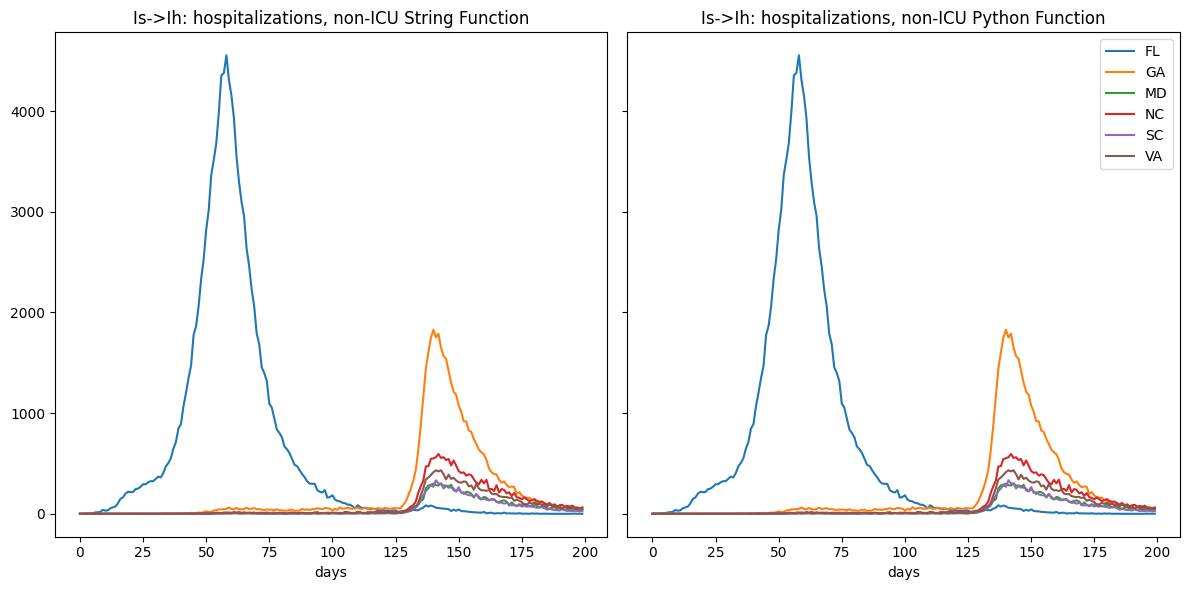

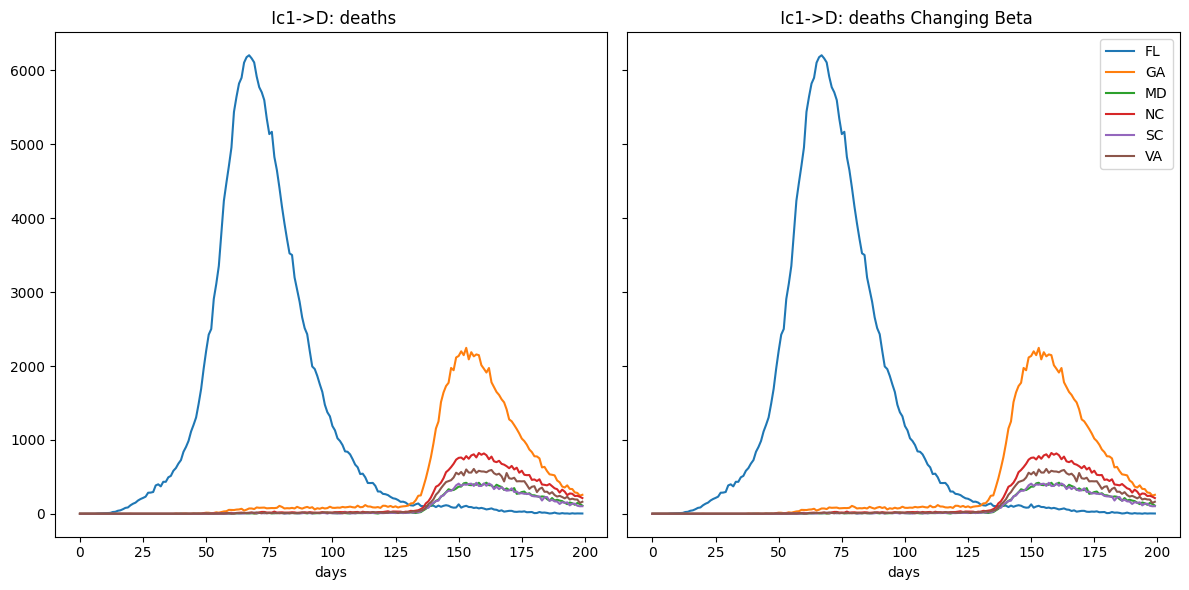

In [20]:
def calculate_beta(t):
    if 0 <= t < 15:
        return 0.7
    elif 15 <= t < 30:
        return 0.2
    elif 30 <= t < 55:
        return 0.4
    elif 55 <= t < 75:
        return 0.1
    elif 75 <= t < 125:
        return 0.15
    elif 125 <= t < 135:
        return 1.2
    elif 135 <= t < 225:
        return 0.1
    else:
        return 1.5


param2 = {
    'move_control': 1,
    'theta': 0.1,
    'beta': 0.3,
    'omega': [0.55,0.05],
    'delta': [0.333, 0.5, 0.166,0.142,0.125],
    'gamma': [0.166, 0.333, 0.25],
    'rho': [0.4, 0.175, 0.015, 0.2, 0.6],
    'beta': calculate_beta ,
}

out6 = sim2.run(
    param=param2,
    start_date=date(2015, 1, 1),
    duration_days=200,
    initializer=init1,
    rng=np.random.default_rng(1)
)

plot_subplots(out5, out6, label1="Prevalence in Florida String Function", label2="Prevalence in Florida Python Function", pop1 = 0,pop2=0, figsize=(24, 12))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
x_axis = np.arange(out6.ctx.clock.num_days)
ax1.plot(x_axis, event_y_axis(out5, 5), label=out5.ctx.labels)
ax2.plot(x_axis, event_y_axis(out6, 5), label=out6.ctx.labels)

ax1.set(title='Is->Ih: hospitalizations, non-ICU String Function', xlabel='days')
ax2.set(title='Is->Ih: hospitalizations, non-ICU Python Function', xlabel='days')
ax2.legend()
fig.tight_layout()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
x_axis = np.arange(out6.ctx.clock.num_days)
ax1.plot(x_axis, event_y_axis(out5, 9), label=out5.ctx.labels)
ax2.plot(x_axis, event_y_axis(out6, 9), label=out6.ctx.labels)

ax1.set(title=' Ic1->D: deaths', xlabel='days')
ax2.set(title=' Ic1->D: deaths Changing Beta', xlabel='days')
ax2.legend()
fig.tight_layout()
plt.show()